# ASTR 596: The Final

#### Three questions, each worth a third of your grade. (I'll make one 34 pts to get to an even 100). Each is designed to test an area where I think the class as a whole is less comfortable. They are sorted by my assesment of difficulty from easiest to hardest. 
#### i.e. the last is probably going to be non-trivial, because well I like Gaussian distributions of grades. 
#### That's OK because the points and grades don't matter!

#### Remember, you can work together, discuss problems and solutions, but you have to write up your own solution. I'd strongly suggest doing that, ideally with some divide and conquer strategy.

In [1]:
#%matplotlib notebook
#%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS# enables direct queries to the SDSS database
import numpy as np
import george
from george import kernels
import scipy
import scipy.stats as st
import emcee
import corner
from astropy.table import Table

### Q1. Using unsupervised learning to work with galaxies

The following query will select 20k likely galaxies from the SDSS database and return the results of that query into an `astropy Table`.  (For now, if you are not familiar with the SDSS DB schema, don't worry about this query, just know that it returns a bunch of photometric features.)

In [1]:

GALquery = """SELECT TOP 20000 
         p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
         p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
         p.petroRad_i, p.petroR50_i, p.deVAB_i, p.fracDev_i
         FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
         WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
         AND p.deVAB_i > -999 AND p.petroRad_i > -999 AND p.petroR50_i > -999 AND p.dered_r < 20
           """
SDSSgals = SDSS.query_sql(GALquery)
SDSSgals

<Table length=20000>
    ug        gr        gi        gz    petroRad_i petroR50_i  deVAB_i  fracDev_i
 float64   float64   float64   float64   float64    float64    float64   float64 
--------- --------- --------- --------- ---------- ---------- --------- ---------
 1.999718 0.9592915  1.370582  1.692535   5.454633   2.344662 0.8708095       1.0
  1.98884 0.9332962  1.361919  1.668918   5.177937   2.424093 0.9946066 0.8865207
 1.020407  1.601521  2.396175  2.827263   5.846272   1.158836 0.6898293       1.0
  1.83742  1.211882  1.688545  1.989878   7.145427   2.795447 0.7493948       1.0
  4.55904  1.536175   2.29286  2.712597   4.741546    2.09032 0.5173162 0.8244159
 4.532835  1.433081  2.251518  2.669952   8.930706   1.656738 0.6116931       1.0
 2.075247  1.267462  1.746914  2.053957   5.091534   2.249913 0.6196061       1.0
 1.677757  1.102043  1.582317  1.902397     6.5472   2.809995 0.8713289 0.9118057
 1.858603 0.9054127  1.364218  1.661177   6.641626    2.84336    0.4171       1.0
      ...       ...       ...       ...        ...        ...       ...       ...
 2.081926 0.9707012   1.36431  1.701037   7.233517   3.043882 0.7853817       1.0
0.8783894  0.348547 0.7083912 0.7549782   2.179495   1.058965 0.5814532 0.3794942
 3.157513   1.68708  2.341705  2.710928   2.444988   1.111298 0.7677339       1.0
 1.212458 0.5644283 0.8961811  1.121565   5.636359   2.755085 0.7131267 0.3723664
 1.969965 0.9283514  1.337235  1.659089   7.834132   3.505748 0.7265089 0.8718476
 1.776455 0.8965893  1.308401  1.640432   5.070049   1.802841 0.5711638       1.0
 2.039864 0.9077148  1.334944  1.678595   2.781022   1.205839 0.6820806       1.0
 2.469046  1.557293  2.112211  2.482569   4.272569   1.796809  0.742517 0.9331489
 1.860246 0.8035107  1.186836  1.488588   17.38426   5.019183 0.8791506       1.0
0.2298508 0.4752026 0.6768112   1.13806   2.291526    1.10566 0.8546982  0.848457

### 1a - Visualize the dataset in g-i (y) vs u-g (x) and all the features (11 pts). 

The bluest galaxies are star-forming galaxies at low redshift 𝑧. The "tight" cluster of red galaxies are passive galaxies at low-𝑧. Finally the diffuse cloud at 𝑔−𝑖≈3 are high-𝑧 luminous red galaxies (LRGs) that were targeted for BAO measurements. These sources have a wide range of 𝑢−𝑔 colors because they essentially are not detected in the 𝑢 band as this is blueward of the Lyman break.

Plot and examine each of the features in this data set using seaborn's `PairGrid`. Overlay a histogram and kernel density distribution (KDE) on each 1D and 2D plot. You should be able to roughly see the different groups of galaxies, but how to separate them?

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

#let's pre-process this mf
#constrains data to within 10 median abs deviations from the median
def mad_filter(data,coloumn):
    mabdev = st.median_abs_deviation(data[column],scale = 'normal',nan_policy='omit')
    mabmask = (data[column] >= np.median(data[column])-15*mabdev) &\
                (data[column] <= np.median(data[column])+15*mabdev)
    return data[mabmask]

for column in SDSSgals.colnames:
    SDSSgals = mad_filter(SDSSgals,column)
    
SDSSgals

<Table length=19931>
    ug        gr        gi        gz    petroRad_i petroR50_i  deVAB_i  fracDev_i
 float64   float64   float64   float64   float64    float64    float64   float64 
--------- --------- --------- --------- ---------- ---------- --------- ---------
 1.999718 0.9592915  1.370582  1.692535   5.454633   2.344662 0.8708095       1.0
  1.98884 0.9332962  1.361919  1.668918   5.177937   2.424093 0.9946066 0.8865207
 1.020407  1.601521  2.396175  2.827263   5.846272   1.158836 0.6898293       1.0
  1.83742  1.211882  1.688545  1.989878   7.145427   2.795447 0.7493948       1.0
  4.55904  1.536175   2.29286  2.712597   4.741546    2.09032 0.5173162 0.8244159
 4.532835  1.433081  2.251518  2.669952   8.930706   1.656738 0.6116931       1.0
 2.075247  1.267462  1.746914  2.053957   5.091534   2.249913 0.6196061       1.0
 1.677757  1.102043  1.582317  1.902397     6.5472   2.809995 0.8713289 0.9118057
 1.858603 0.9054127  1.364218  1.661177   6.641626    2.84336    0.4171       1.0
      ...       ...       ...       ...        ...        ...       ...       ...
 2.081926 0.9707012   1.36431  1.701037   7.233517   3.043882 0.7853817       1.0
0.8783894  0.348547 0.7083912 0.7549782   2.179495   1.058965 0.5814532 0.3794942
 3.157513   1.68708  2.341705  2.710928   2.444988   1.111298 0.7677339       1.0
 1.212458 0.5644283 0.8961811  1.121565   5.636359   2.755085 0.7131267 0.3723664
 1.969965 0.9283514  1.337235  1.659089   7.834132   3.505748 0.7265089 0.8718476
 1.776455 0.8965893  1.308401  1.640432   5.070049   1.802841 0.5711638       1.0
 2.039864 0.9077148  1.334944  1.678595   2.781022   1.205839 0.6820806       1.0
 2.469046  1.557293  2.112211  2.482569   4.272569   1.796809  0.742517 0.9331489
 1.860246 0.8035107  1.186836  1.488588   17.38426   5.019183 0.8791506       1.0
0.2298508 0.4752026 0.6768112   1.13806   2.291526    1.10566 0.8546982  0.848457

In [3]:
#let's plot this mf

#first turn this mf into a pd because issues
SDSS_pd = SDSSgals.to_pandas().dropna()

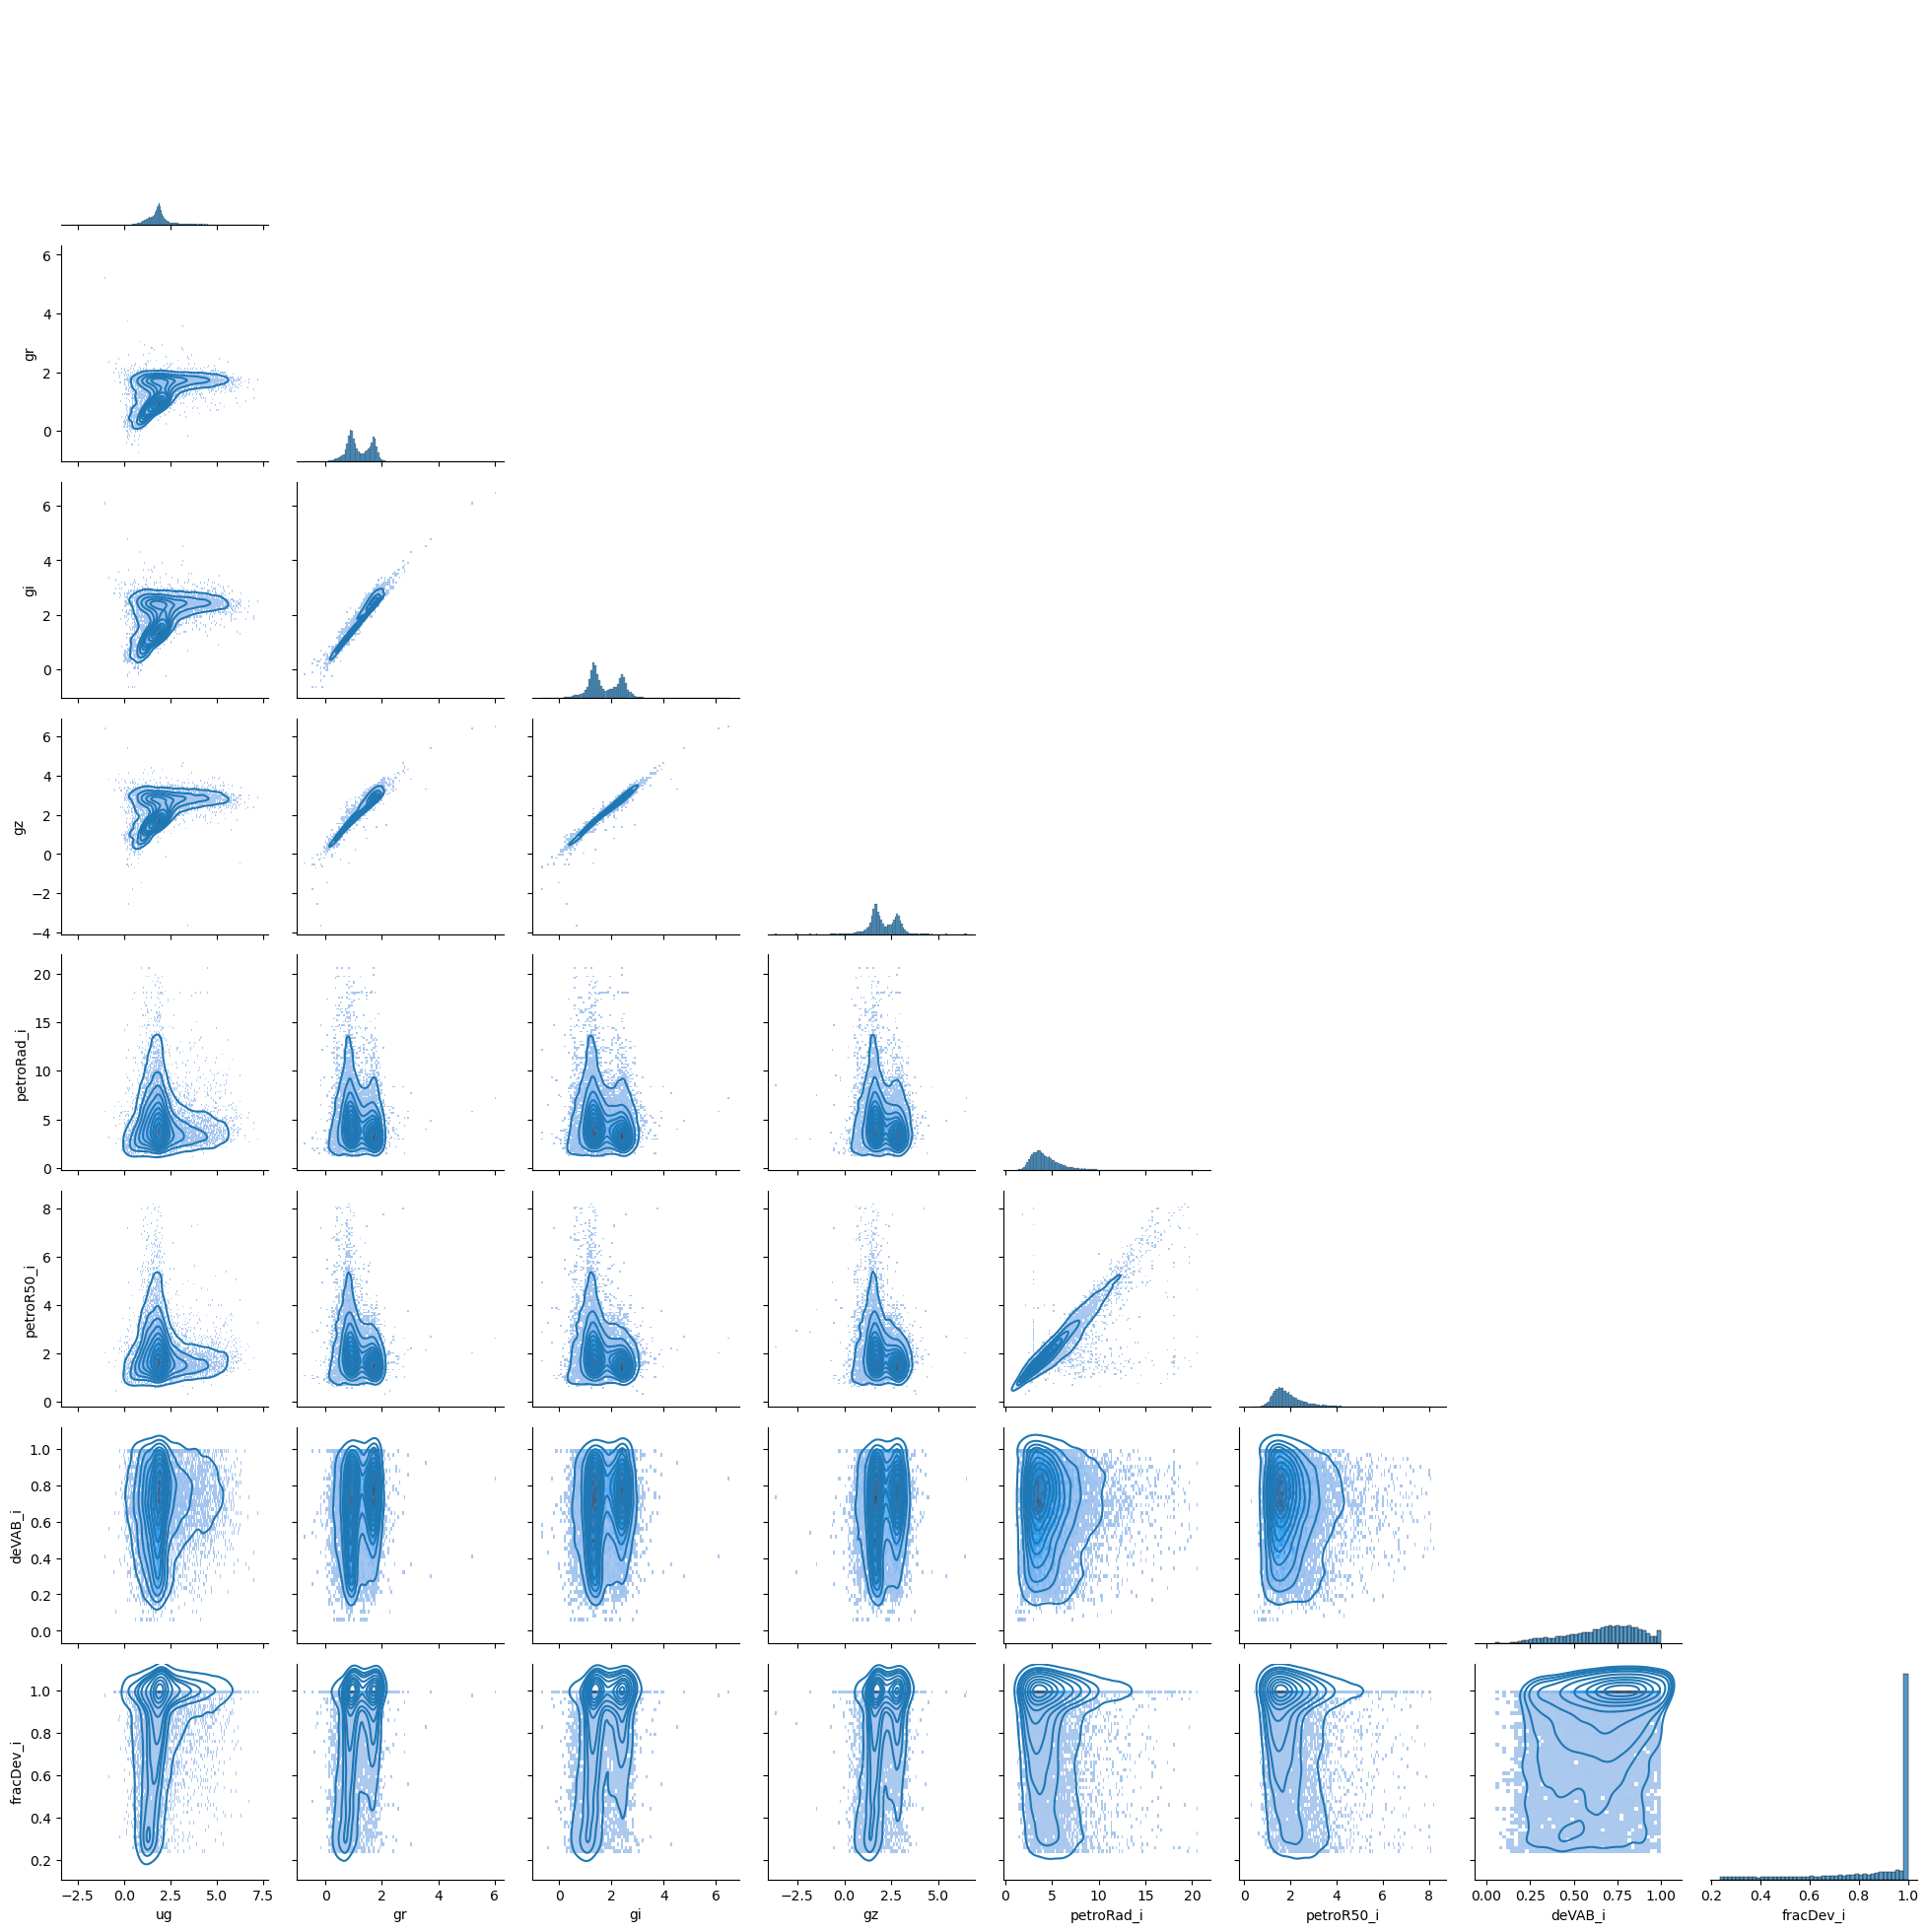

In [84]:
pgrid = sns.PairGrid(SDSS_pd, corner=True)
pgrid.map_diag(sns.histplot)#every 1D plot
pgrid.map_offdiag(sns.histplot)#every 2D plot

#for some reason trying to run the kdeplot takes forever to run and never finishes, 
# I will hopefully debug this eventually, but if I don't please pretend I ran the next line of code
pgrid.map_offdiag(sns.kdeplot)

### 1b - Separating the galaxy types (11 pts) 

Using K-means from `sklearn` with n=3, separate the three clusters of galaxies. Initial guesses, hyper-paramter tuning, dimensionality reduction etc are your choices. What's important is to be able to justify them. To the referee, to me, to yourself. We'll do that in the next part. 

In [4]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#scales data based on mean and standard dev
scale = StandardScaler(with_mean=True, with_std =True)
scaldat = scale.fit_transform(SDSS_pd)
#create a label for each cluster based on K-means
kmeans = KMeans(3,n_init='auto')
labels = kmeans.fit_predict(scaldat)
labs = np.unique(labels)
print(labs)
print(scaldat)

[0 1 2]
[[ 0.11377838 -0.35136979 -0.41624763 ...  0.24474598  1.02256795
   0.74003066]
 [ 0.10159163 -0.40639151 -0.42998943 ...  0.32429497  1.62352448
   0.40647211]
 [-0.98335506  1.00797504  1.21061253 ... -0.94284142  0.14402367
   0.74003066]
 ...
 [ 0.63957196  0.91436192  0.76017096 ... -0.30392079  0.39978909
   0.54353001]
 [-0.04247372 -0.68109588 -0.7077171  ...  2.92323967  1.06305871
   0.74003066]
 [-1.86902432 -1.37599376 -1.51675054 ... -0.99609641  0.94435779
   0.2945885 ]]


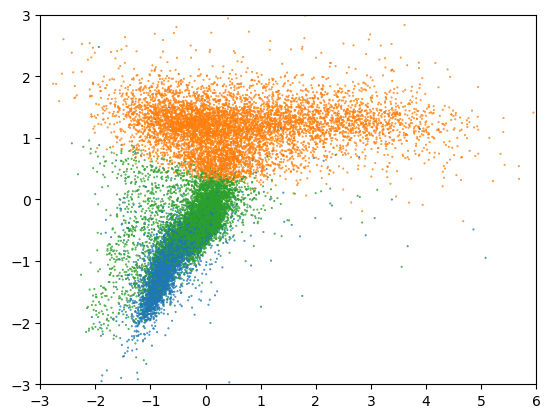

In [5]:
colors = []
for lab in labels:
    colors.append('C{}'.format(lab))
plt.figure()
#plot ug vs gi
# shows different labels assigned to data
plt.scatter(scaldat[:,0],scaldat[:,2],c=colors,s=0.2)
plt.xlim(-3,6)
plt.ylim(-3,3)
plt.show()

### 1c - Working with the distributions (11 pts)
Repeat 1a, but using the results of K-means in 1b to create separately colored distributions for your different classes of galaxies. Use the KDE to provide the mean values of each feature and their standard deviation (hint - these are integrals), and compare them to the sample means and standard deviations. 

In [6]:
SDSS_pd['labels'] = labels#add labels column so we can add colors to pairgrid

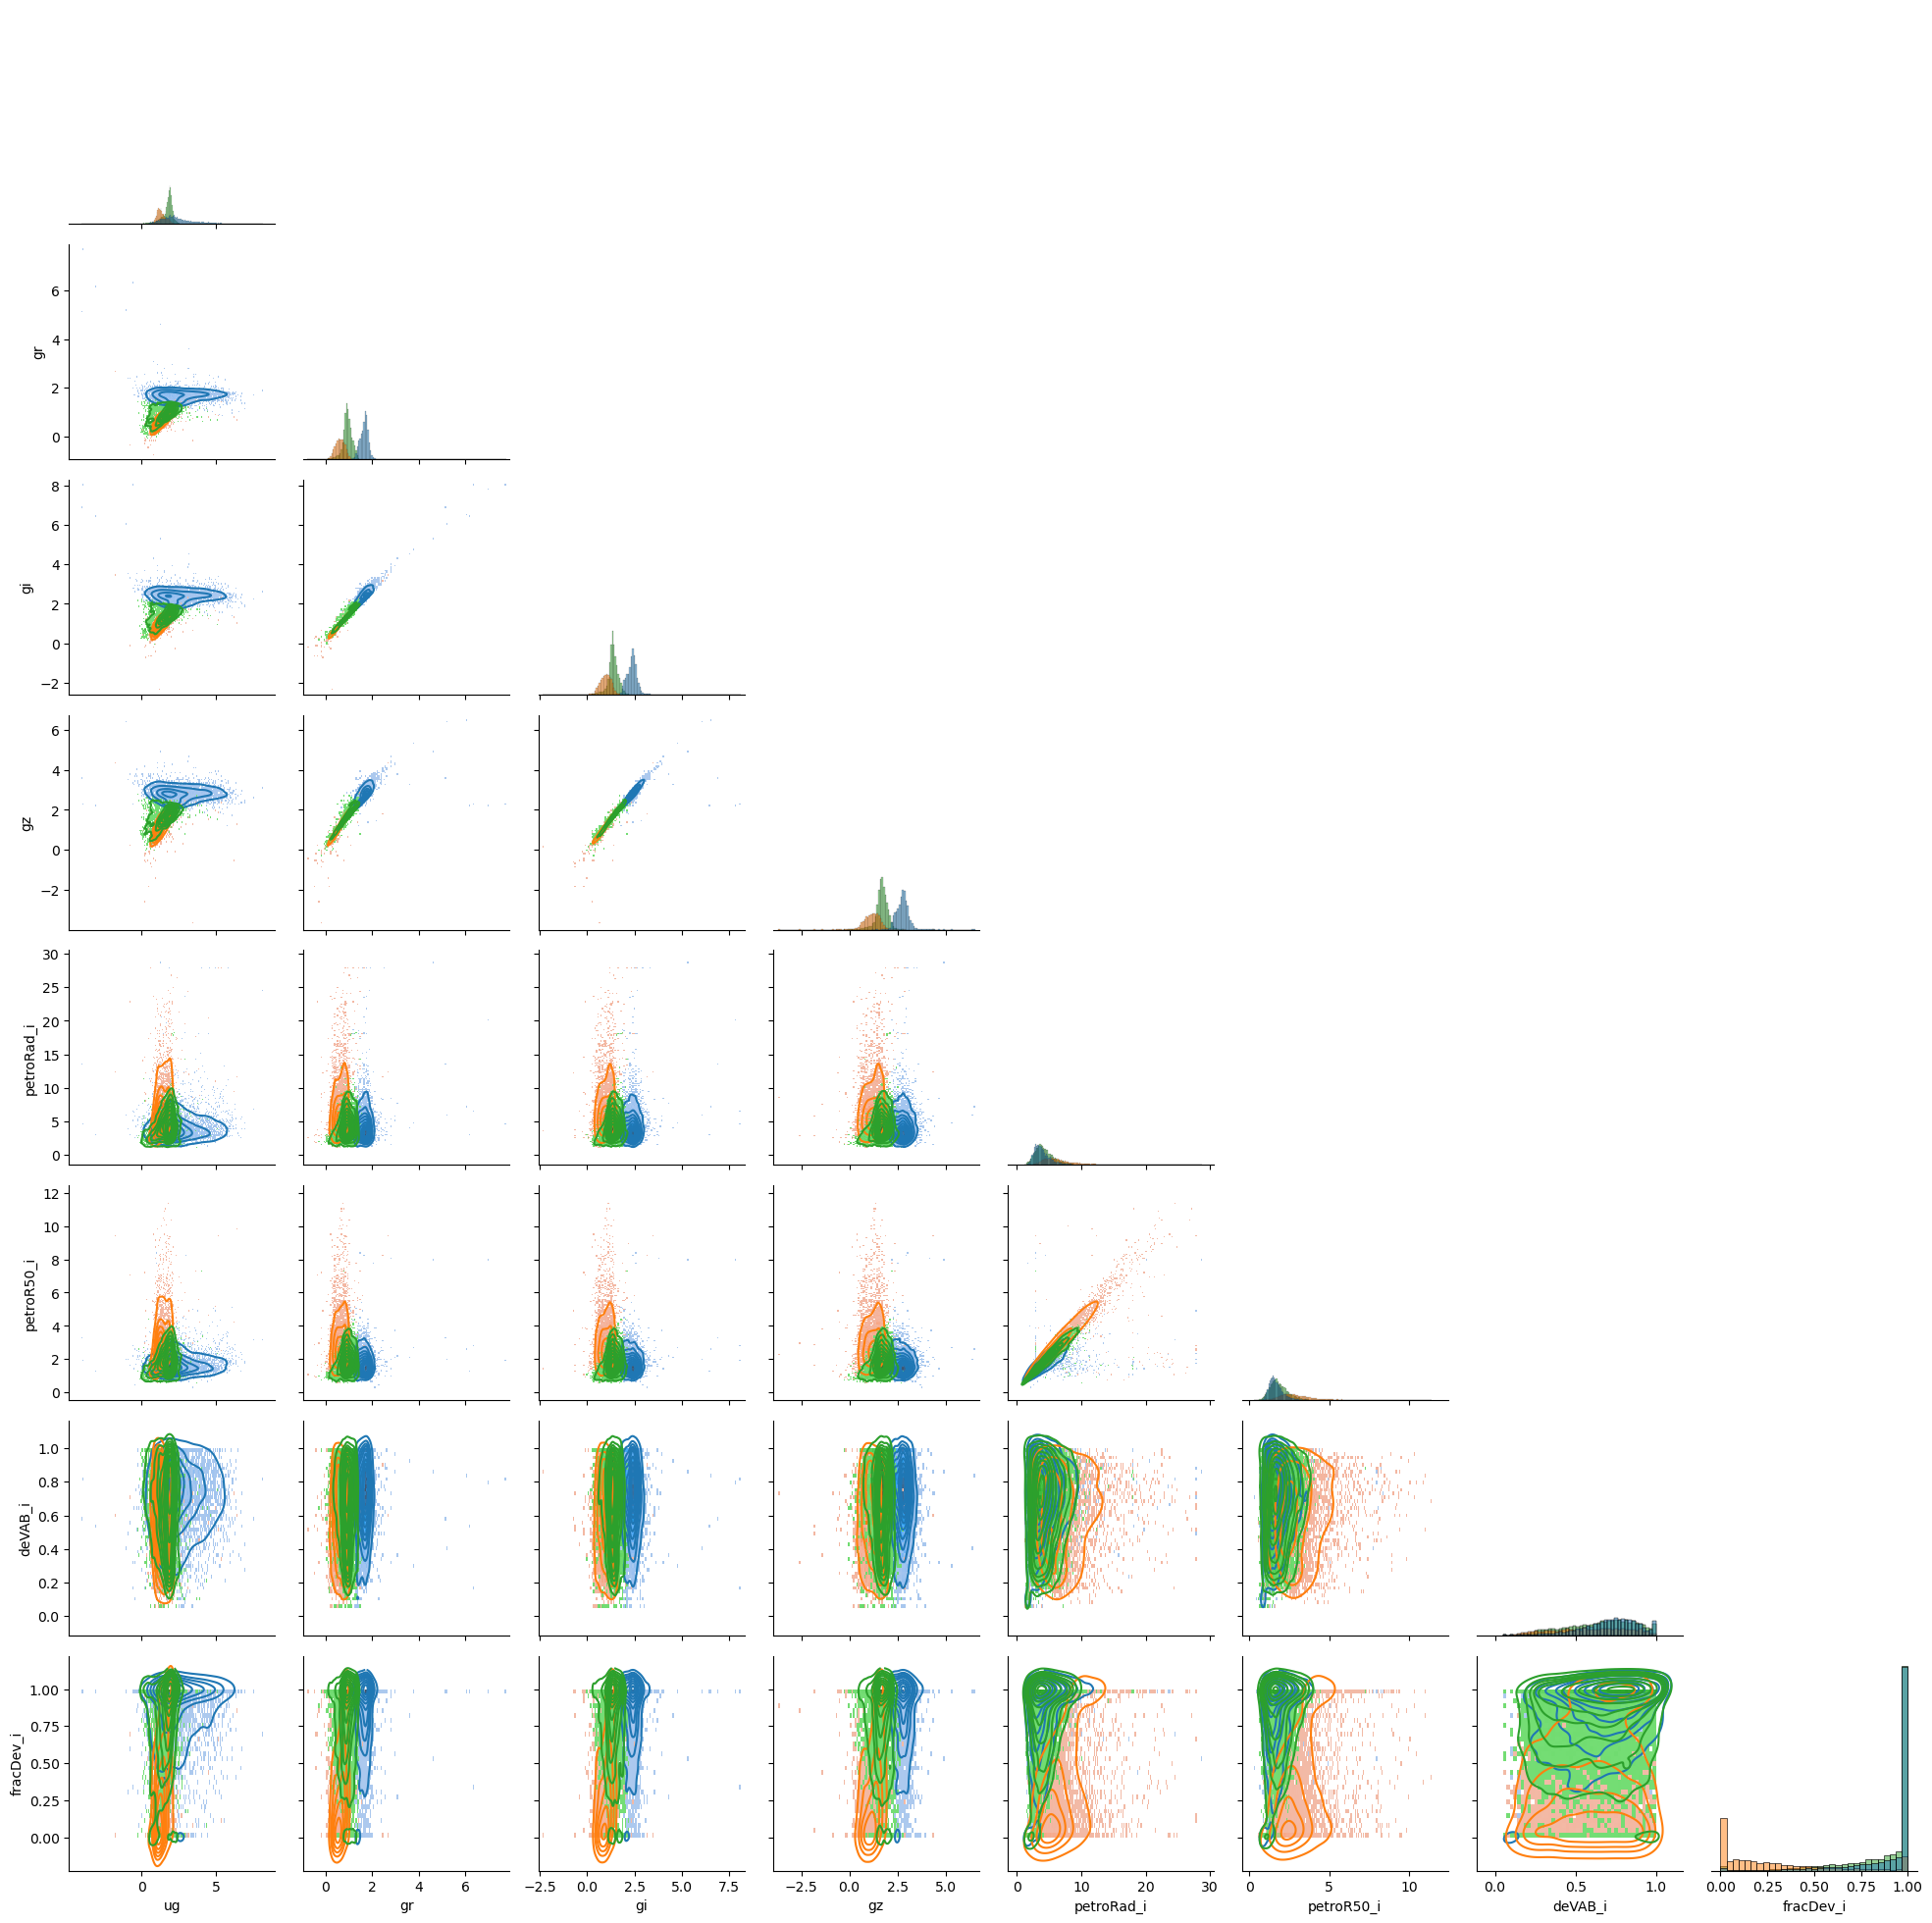

In [16]:
sns.PairGrid(SDSS_pd, hue='labels',palette=sns.color_palette(n_colors=3),corner=True)
pgrid2.map_diag(sns.histplot)#every 1D plot
#this actually takes like 10 minutes to run...
pgrid2.map_offdiag(sns.kdeplot)
pgrid2.map_offdiag(sns.histplot)#every 2D plot

['ug' 'gr' 'gi' 'gz' 'petroRad_i' 'petroR50_i' 'deVAB_i' 'fracDev_i']
Values from KDE integrals
Means
 labels          ug                 gr         ...     petroR50_i         deVAB_i            fracDev_i     
-------- ------------------ ------------------ ... ----------------- ------------------ -------------------
all data  1.898158843491827 1.1252980085870117 ... 2.100278684165435 0.6601372513881618  0.7476870234895461
       0 1.3440399278788135 0.6248740691884702 ... 3.140736311336622 0.5828584700947037 0.28482772077250196
       1 2.4564925585062736  1.669594133003126 ... 1.701523688829188 0.7120289513607834  0.9039437348021673
       2  1.729513055195659 0.9395581156116922 ... 1.874819336558592 0.6582893410042426  0.8657771853471686
Standard Deviations
 labels           ug                  gr          ...      petroR50_i           deVAB_i             fracDev_i      
-------- ------------------- -------------------- ... ------------------- -------------------- -------------------

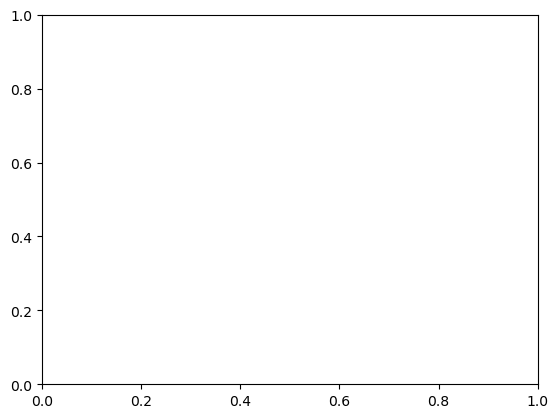

In [7]:

#integrate the kde data to get means and std devs
def kdeint(feature):
    kde = sns.kdeplot(feature);
    kdelines = kde.lines[0]
    x = kdelines.get_xdata()
    y = kdelines.get_ydata()
    mean = np.sum(x[1:]*y[1:]*(x[1:]-x[:-1]))
    std = 0.5*np.sum((x[1:]-x[:-1])*((x[1:]-mean)**2)*y[1:])
    kde.clear();
    return mean,std
cols = SDSS_pd.drop(columns='labels').columns.values#removes labels column, will be added back later but include all data
print(cols)
means = []
std_devs = []
for col in cols:
    kdeint1 = kdeint(SDSS_pd[col])
    mean = [kdeint1[0]]
    std = [kdeint1[1]]
    for label in labs:
        mask = SDSS_pd['labels']==label
        kdeint2 = kdeint(SDSS_pd[col][mask])
        mean.append(kdeint2[0])
        std.append(kdeint2[1])
    means.append(mean)
    std_devs.append(std)
    
print('Values from KDE integrals')
label_names = ['all data', *labs]#make sure label list includes label for whole data set
#generate a table of means for all data plus each class
mean_tab = Table([label_names, *means],names = ['labels',*cols])
print('Means')
print(mean_tab)

#generate a table of std for all data plus each class
std_tab =  Table([label_names, *std_devs],names = ['labels',*cols])
print('Standard Deviations')
print(std_tab)

In [8]:
#same as above
cols = SDSS_pd.drop(columns='labels').columns.values#removes labels column, will be added back later but include all data
print(cols)
means = []
std_devs = []
for col in cols:
    mean = [np.mean(SDSS_pd[col])]
    std = [np.std(SDSS_pd[col])]
    for label in labs:
        mask = SDSS_pd['labels']==label
        mean.append(np.mean(SDSS_pd[col][mask]))
        std.append(np.std(SDSS_pd[col][mask]))
    means.append(mean)
    std_devs.append(std)
    
print('Values direct from each feature')
label_names = ['all data', *labs]#make sure label list includes label for whole data set
mean_tab = Table([label_names, *means],names = ['labels',*cols])#generate a table of means for all data plus each class
print('Means')
print(mean_tab)

std_tab =  Table([label_names, *std_devs],names = ['labels',*cols])
print('Standard Deviations')
print(std_tab)

['ug' 'gr' 'gi' 'gz' 'petroRad_i' 'petroR50_i' 'deVAB_i' 'fracDev_i']
Values direct from each feature
Means
 labels          ug                 gr         ...     petroR50_i          deVAB_i           fracDev_i     
-------- ------------------ ------------------ ... ------------------ ------------------ ------------------
all data 1.8981584156198885 1.1252979749355274 ...  2.100279017650896 0.6601604111404344 0.7482356259803422
       0  1.344038969226164  0.624873905909091 ... 3.1407383974279375  0.582866689361419 0.2848465974623503
       1  2.456491918088097 1.6695946745260155 ... 1.7015243562651459 0.7120651701140414 0.9046190230849609
       2  1.729513303012372 0.9395581704722816 ... 1.8748200772305497 0.6583144440958839 0.8663482821696408
Standard Deviations
 labels          ug                  gr         ...     petroR50_i           deVAB_i            fracDev_i     
-------- ------------------ ------------------- ... ------------------ ------------------- -------------------
al

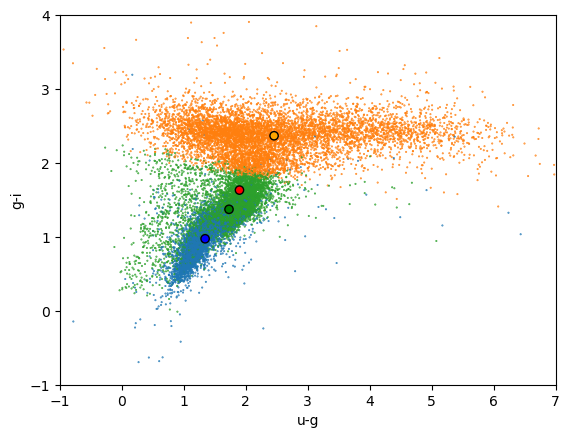

In [9]:
plt.figure()
#plot ug vs gi
# shows different labels assigned to data
plt.scatter(SDSS_pd['ug'],SDSS_pd['gi'],c=colors,s=0.2)

mean_c = ['r','blue','orange','green']

plt.scatter(mean_tab['ug'],mean_tab['gi'], c = mean_c, marker='o',edgecolors='black')

plt.ylim(-1,4)
plt.xlim(-1,7)
plt.xlabel('u-g')
plt.ylabel('g-i')
plt.show()

### Q2. Gaussian Processes + Emcee

There are many sources with periodic light curves that are not strictly sinusoidal. Thus, the use of the cosine kernel (on its own) may not be sufficient to model the signal. The quasi-periodic kernel: 

$$K_{ij} = k(x_i - x_j) = A \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

is useful for non-sinusoidal signals. It is implemented in the `george` package. Note that the parameters in the kernel aren't the only parameters you might need... look back on your previous homework assignments and think about what I'm glossing over here. 

I've given you an example light curve file with a decidedly non-sinusoidal, periodic signal from the ASAS-SN project from our colleagues at OSU. 

### 2a - Implement the model  (11 pts)

Examine this data, filter it as you see fit (I've included the file header in full - I'd pick one aperture, and look at the grades and notes about separate datasets). You can make tradeoffs here - more data that is potentially messier, vs less data so weaker constraints, but cleaner. Pick something that you can justify (and if you're struggling at 2c, examine this choice before twiddling with emcee). 

Write down a model for it with the likelihood function, an appropriate prior and posterior.

You may wish to look at the `george` documentation again, particularly how some parameters are better log transformed if the expectation is that they are positive real values. 

https://george.readthedocs.io/en/latest/tutorials/model/

In [2]:
from astropy.io import ascii

data = ascii.read('asas_data.dat')#, header_start = 0, data_start = 1, comment='#')
data

<Table length=1294>
   HJD      MAG_1   MAG_0   MAG_2   MAG_3   MAG_4   MER_1   MER_0   MER_2   MER_3   MER_4  GRADE FRAME 
 float64   float64 float64 float64 float64 float64 float64 float64 float64 float64 float64  str1 int64 
---------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ----- ------
1869.74854   12.26  12.271  12.226  12.184   12.19    0.03   0.058   0.027   0.031   0.037     A    292
1875.76359  11.497  11.548  11.495  11.507  11.523   0.031   0.069   0.028   0.032   0.041     B   1221
1877.76186  12.222  12.248  12.222  12.246  12.284   0.029    0.05   0.025   0.029   0.033     A   1539
1879.75361  12.023  12.049  12.048  12.054  12.049   0.026   0.037   0.024   0.027   0.032     A   1851
1881.72783  11.561  11.549  11.553  11.542  11.538   0.029   0.045   0.025   0.027   0.032     A   2154
1884.70932  11.637  11.669  11.661  11.676  11.666    0.03   0.045   0.026   0.028   0.034     A   2295
1885.71965  12.034  12.073  12.038  12.064  12.092    0.03    0.04   0.024   0.027   0.031     A   2459
1887.71443  11.745  11.802   11.72  11.715  11.717   0.032   0.051   0.027    0.03   0.036     A   2776
1888.71132  12.174  12.163  12.162  12.181  12.157    0.03   0.052   0.027    0.03   0.035     A   2935
       ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...   ...    ...
5118.81723  12.119  12.136  12.194  12.223  12.258   0.081   0.068   0.063   0.062   0.066     D 330346
5123.83111  12.032  12.054  12.072   12.06  12.071   0.049   0.047   0.047   0.051   0.055     B 330804
5128.84484  11.788  11.843  11.841  11.812  11.798   0.055   0.053   0.051   0.054   0.057     D 331391
 5131.8245   11.83  11.858  11.863  11.879  11.947   0.056   0.048   0.043   0.046    0.05     B 331799
5136.84775  11.505  11.478  11.515  11.528   11.56   0.054   0.057   0.059   0.067   0.077     D 332140
5154.83688  12.223  12.232  12.243  12.251  12.302   0.048   0.047   0.044   0.047    0.05     B 333419
5158.74645    12.4   12.48  12.479  12.401  12.427   0.085    0.06   0.058   0.062   0.067     D 333842
5162.78817  11.888  11.871   11.86  11.871  11.879   0.047   0.046   0.045   0.048   0.052     B 334245
5165.75062   11.92  11.923  11.906  11.904  11.864   0.048   0.045   0.042   0.048   0.055     A 334609
5168.73891  12.017  11.981  11.976  11.925  11.885   0.052   0.049   0.048   0.055   0.062     D 334955

In [3]:
#only selects grade A data and sorts sequentially
grademask = data['GRADE'] == 'A'
data=data[grademask]
data=data[data['HJD'].argsort()][::2]

<ErrorbarContainer object of 3 artists>

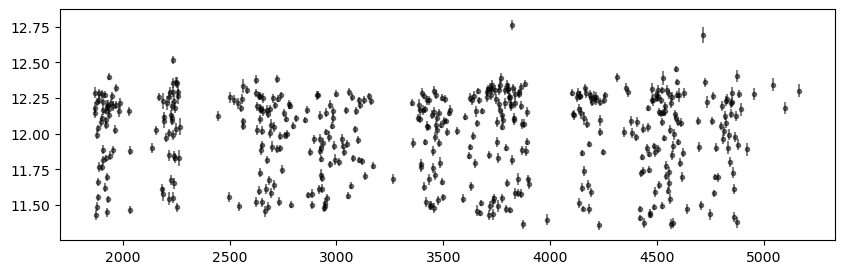

In [4]:
plt.figure(figsize=(10,3))
#don't use MAG_1 or MAG_0 due to column order being flipped in dataset
plt.errorbar(data['HJD'], data['MAG_2'], yerr = data['MER_2'],c='k',linestyle='',\
             marker='.',alpha=0.5)

In [38]:
#assume that all parameters are positive, therefore use logs
def kernel(logA, gamma,logP):
    return np.exp(logA)*kernels.ExpSine2Kernel(gamma=np.exp(gamma), log_period=logP)

In [6]:
meanmag = np.mean(data['MAG_2'])
stdmag = np.std(data['MAG_2'])

print(meanmag,stdmag)

11.990141414141414 0.28511908588053825


In [7]:
#define a model; for now just base it on the mean value 
from george.modeling import Model

Text(0, 0.5, 'Mag')

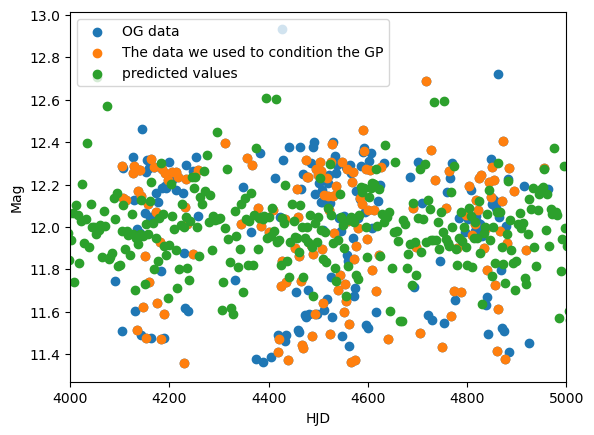

In [8]:
initg = [0.5,15,np.log(20)]
# Define a Gaussian Process - you need a mean and a kernel 
gp = george.GP(mean=meanmag, kernel=kernel(*initg))

t2 = np.asarray(data['HJD'][::2]) #use every other time value
mag2 = np.asarray(data['MAG_2'][::2])

gp.compute(t2)
t_new = np.linspace(np.min(data['HJD']), np.max(data['HJD']), 1000)
mag_new = gp.predict(mag2, t_new, return_cov=False)



plt.scatter(data['HJD'], data['MAG_2'], label = 'OG data')
plt.scatter(t2, mag2, label = 'The data we used to condition the GP')
plt.scatter(t_new, mag_new, label = 'predicted values')
plt.legend()
plt.xlim(4000,5000)
plt.xlabel('HJD')
plt.ylabel('Mag')

In [39]:
def lnpriors(theta):
    mag_val, logA, gamma, logP = theta
    #don't have a good guess for gamma, but assume it's positive
    if (gamma <= -10 or gamma > 10) or (mag_val > meanmag+10*stdmag or mag_val<meanmag-10*stdmag) or\
        (logA < -10 or logA>10) or (logP>5 or logP < -5):# I know this is a huge range for the parameters,
        return -np.inf                                # but for now im being generous
    else:
        pm = st.norm.logpdf(mag_val,loc = meanmag, scale=stdmag)
        pA = st.norm.logpdf(logA, loc=-.3, scale=1)
        plP = st.uniform.logpdf(logP,loc=-1, scale=4)
        pg = st.uniform.logpdf(gamma, loc = -10, scale = 20)
        logprior = pm + pA + plP + pg
        return logprior

def nlnL(theta, *args):
    mag_val, A, gamma, logP = theta 
    t, m, m_err = args
    gp = george.GP(mean=mag_val, kernel=kernel(A, gamma, logP))
    gp.compute(t, m_err)

    lnL = gp.log_likelihood(m-mag_val, quiet=True)
    return lnL
    
def log_posterior(theta, *args):
    if not np.isfinite(lnpriors(theta)):
        return -np.inf
    post = lnpriors(theta) + nlnL(theta, *args)
    return post

### 2b - Initial Guesses (11 pts)

Make some initial guess for the parameters. For the period, use Lomb-Scargle to find the top three periods for this light curve. Initialize 1/3rd of the walkers to each of the top three periods

Do the burn in with `emcee` - a 100 walkers and a 1000 steps should be plenty - you should find that the walkers have migrated away from the starting guess. Plot the chains. 

Make a plot of the log of the Posterior vs the log of the Period - select the periods with the highest log Posterior and change the initial guess for the Period of all the walkers to be in a small region around the Period with the highest log Posterior. 

[1.35659566 0.64611461 0.35386539]
[0.73713932 1.54771303 2.82593336]


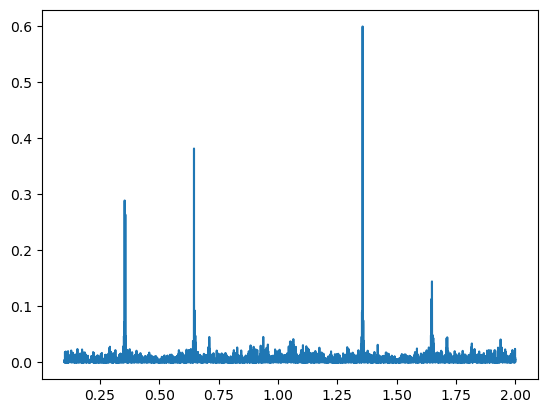

In [10]:
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks

freq = np.linspace(0.1,2,10000)
power = LombScargle(data['HJD'][::1], data['MAG_2'][::1],data['MER_2']).power(freq)#samples_per_peak=5)
plt.plot(freq,power)
peakind, _ = find_peaks(power, distance=50)
peak_sort = np.argsort(-1*power[peakind])
freq_peaks = freq[peakind]
top_freqs = freq_peaks[peak_sort]
print(top_freqs[0:3])
print(1/top_freqs[0:3])

In [11]:
ndim= 4
nwalkers = 100
nburn = 1000
p0 = np.array([meanmag, np.log(0.5), np.log(5),0])+ 0.001*np.random.randn(nwalkers, ndim)

#set 1/3 of the walkers to each of the top frequencies, plus some randomness
p0[0:33, 3] = np.log((1/top_freqs[0])) + 1e-4*np.random.randn(33)
p0[33:67, 3] = np.log((1/top_freqs[1])) + 1e-4*np.random.randn(34)
p0[67:100, 3] = np.log((1/top_freqs[2])) + 1e-4*np.random.randn(33)
print(p0)

[[11.99095843 -0.69325678  1.60788846 -0.30492441]
 [11.99081538 -0.69367884  1.6103281  -0.30492422]
 [11.98843224 -0.69219739  1.6091875  -0.30492163]
 [11.9920114  -0.69226878  1.61009076 -0.30489358]
 [11.99053624 -0.69318719  1.60814216 -0.30481255]
 [11.99139961 -0.692447    1.6088844  -0.30505359]
 [11.98978193 -0.69362383  1.60920905 -0.30499314]
 [11.98978243 -0.6933648   1.60952068 -0.30511732]
 [11.9872178  -0.69200914  1.60975758 -0.30490717]
 [11.98909371 -0.69213476  1.60856244 -0.3050814 ]
 [11.99046536 -0.69309395  1.60954391 -0.30490796]
 [11.98921326 -0.69310443  1.61269496 -0.30507046]
 [11.99034656 -0.69387911  1.6089315  -0.30489148]
 [11.99112146 -0.69267209  1.60979823 -0.3049406 ]
 [11.98980068 -0.69270187  1.60852129 -0.30507964]
 [11.9907746  -0.69401211  1.60934738 -0.30495191]
 [11.99172137 -0.69209473  1.60679197 -0.30499906]
 [11.98841247 -0.69346176  1.60979379 -0.30493589]
 [11.98930089 -0.69258821  1.61023316 -0.30498103]
 [11.99086891 -0.69095658  1.61

In [12]:
t = np.asarray(data['HJD'])
mag = np.asarray(data['MAG_2'])
m_err = np.asarray(data['MER_2'])
from multiprocessing import Pool
#hoping that pool speeds this up somehow...
filename = "samples.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, \
                                 args = (t, mag, m_err), backend=backend)
state = sampler.run_mcmc(p0, nburn, progress=True,store=True)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:47<00:00,  5.98it/s]


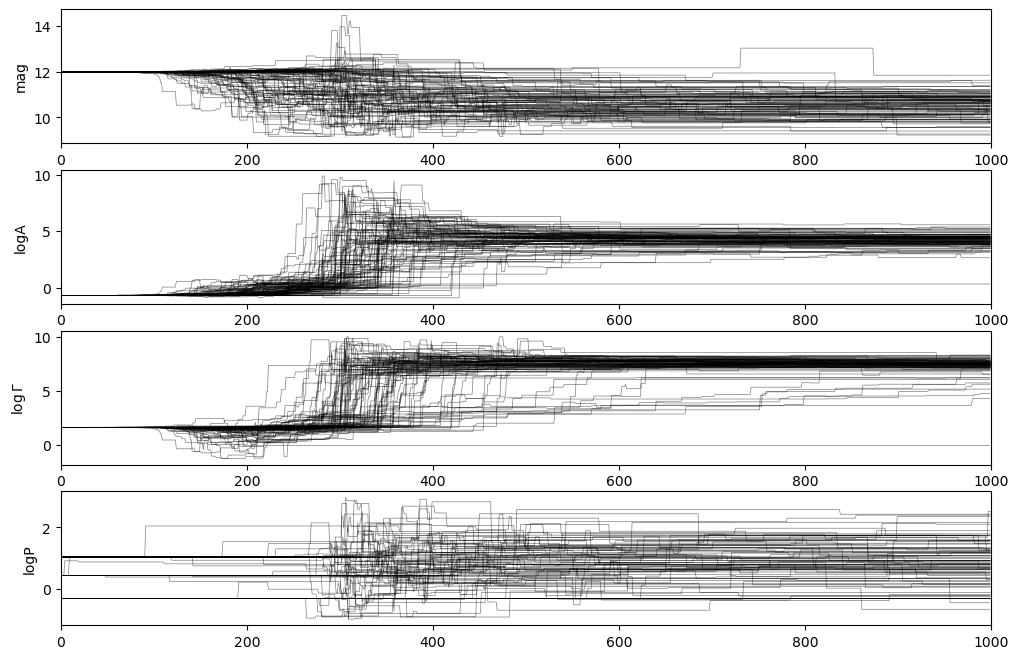

In [13]:
fig, ax = plt.subplots(4,1, figsize = (12,8))
labels=['mag','logA', r'$\log\Gamma$', 'logP']
samples = emcee.backends.HDFBackend(filename)
chains = samples.get_chain(flat=False)
for i in range(4):
    ax[i].plot(chains[:,:,i], color='k', alpha = 0.5, lw = 0.5)
    ax[i].set_ylabel(labels[i])
    ax[i].set_xlim(0, 1000)

(100,)
(100,)


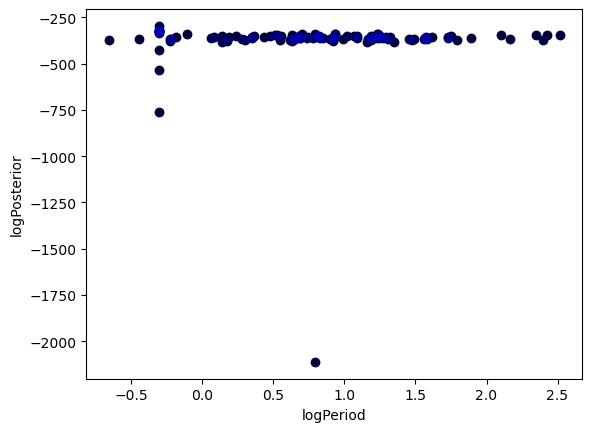

In [14]:
logprob = samples.get_log_prob()[-1,:]
logprob2 = sampler.lnprobability[:,-1]
print(logprob.shape)
logper = chains[-1,:,3]
logper2 = sampler.chain[:,-1,3]
print(logper.shape)
plt.scatter(logper, logprob, c='k', marker='o')
plt.scatter(logper2, logprob2, c='b', marker='o',alpha = 0.2)
plt.xlabel('logPeriod')
plt.ylabel('logPosterior')
plt.show()

In [15]:
bestper = logper[np.argmax(logprob)]
maxind = np.argmax(logprob)
print(maxind)
print(bestper, np.exp(bestper))

3
-0.3049978048547388 0.7371249924862859


In [16]:
p0[:,3] = bestper +1e-4*np.random.randn(nwalkers)
p02 = chains[-1,maxind, :] + 1e-6*np.random.randn(nwalkers, ndim)
#print(chains[-1,maxind, :]==sampler.chain[maxind, -1, :])

In [17]:
nsteps = 2000

filename2 = "samples2.h5"
backend2 = emcee.backends.HDFBackend(filename2)
backend2.reset(nwalkers, ndim)
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, \
                                 args=(t,mag,m_err),backend = backend2)
state2 = sampler2.run_mcmc(p02, nsteps, progress=True,store=True)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:24<00:00,  6.17it/s]


### 2c - Infer the model parameters (11 pts)

Plot the chains, the corner plot, the folded lightcurve, the Gaussian process model given the median parameters, 10 other draws from the model and the uncertainty about the model. 


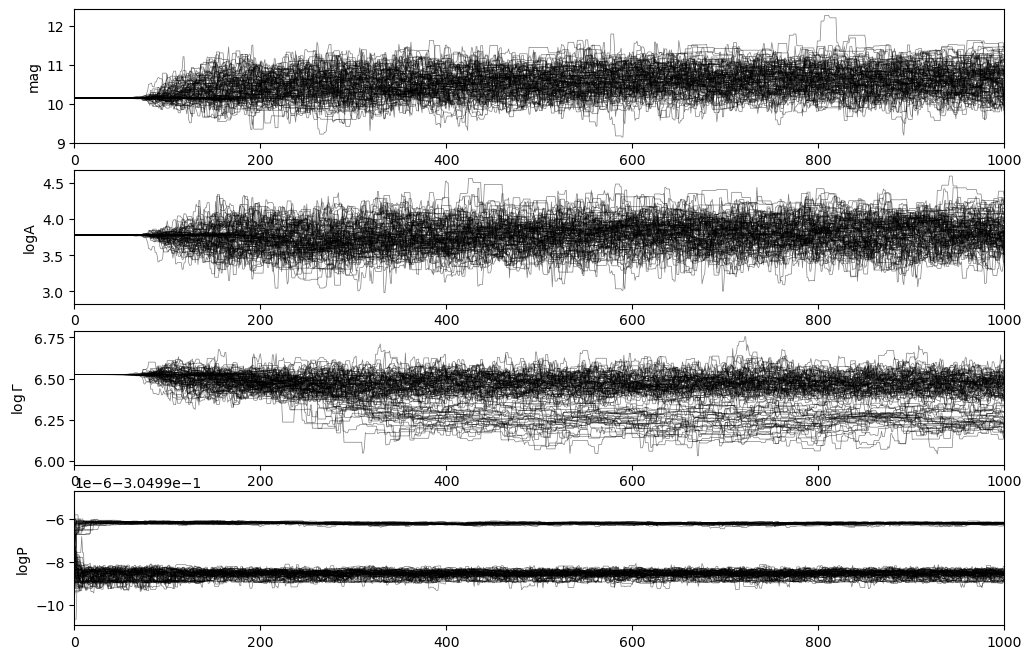

In [18]:
#plot the chains
fig, ax = plt.subplots(4,1, figsize = (12,8))
labels=['mag','logA', r'$\log\Gamma$', 'logP']
samples2 = emcee.backends.HDFBackend(filename2)
chains2 = samples2.get_chain(flat=False)
for i in range(4):
    ax[i].plot(chains2[:,:,i], color='k', alpha = 0.5, lw = 0.5)
    ax[i].set_ylabel(labels[i])
    ax[i].set_xlim(0, 1000)

(200000, 4)
(200000, 4)


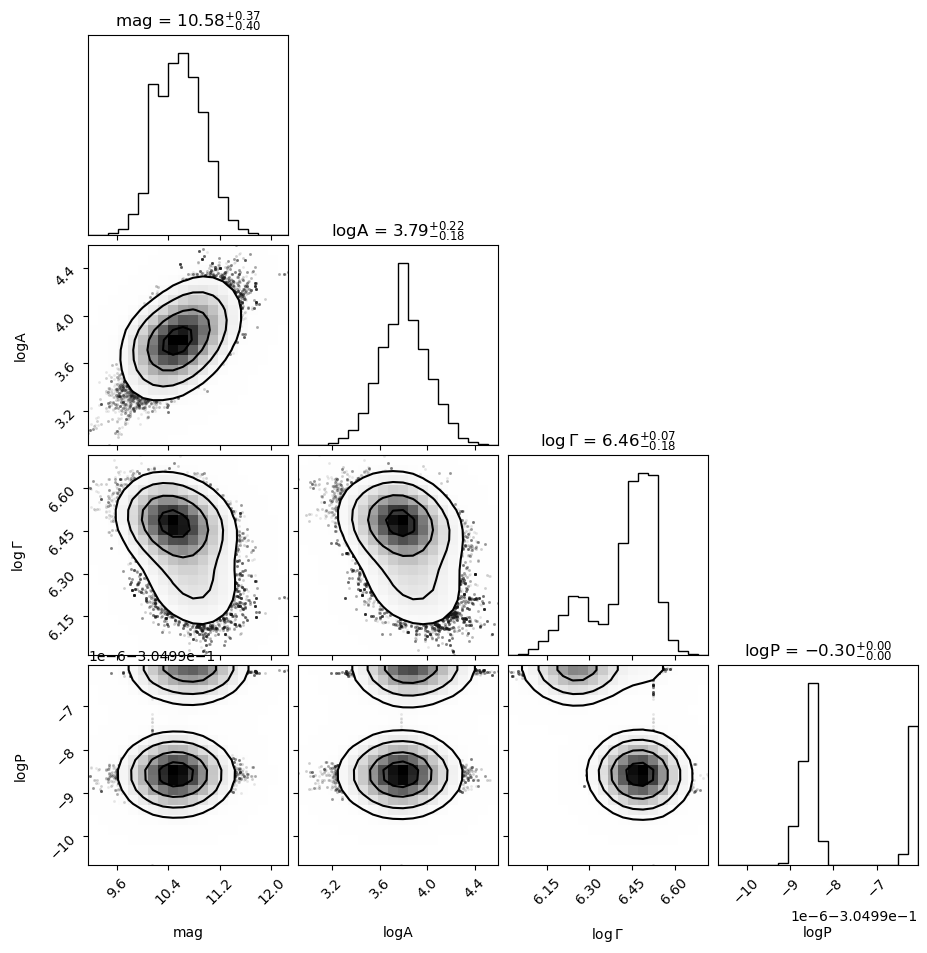

In [27]:
samples = sampler2.flatchain
print(samples.shape)
chains2 = samples2.get_chain(flat=True)
print(chains2.shape)
corner.corner(chains2[100::2],labels=labels, plot_contours=True, show_titles=True,smooth=2);

In [28]:
mcmc_res = np.percentile(chains2[::], 50, axis=0) #median of chain values
bestper = mcmc_res[3]
print(bestper)

-0.3049984638866422


0.7371245066975591
[12.16622137 12.15612385 12.14029463 12.12437748 12.11411627 12.11366275
 12.12434441 12.14428771 12.16896258 12.19252301 12.20951088 12.21645062
 12.21284107 12.20126201 12.18656541 12.17440567 12.16955146 12.17448875
 12.18873645 12.20905784 12.23048247 12.24780629 12.25711181 12.25685385
 12.24821357 12.23464928 12.22081181 12.21116757 12.20872516 12.21420381
 12.22584352 12.239875   12.25148337 12.25603326 12.2502451  12.23307313
 12.20610781 12.17342158 12.14088432 12.11508504 12.10203957 12.10594853
 12.12823248 12.1670783  12.21759523 12.27259654 12.32386022 12.36363233
 12.38604284 12.38816242 12.37046076 12.33660701 12.29267882 12.24598333
 12.2037475  12.1719587  12.15451805 12.15283427 12.16582923 12.19029354
 12.2214781  12.2538312  12.2817969  12.30061079 12.30702775 12.29987976
 12.28037305 12.25199955 12.22002623 12.19058445 12.16950423 12.16112589
 12.16736484 12.18727    12.21721032 12.25166534 12.28444792 12.31006016
 12.32486361 12.32777667 12.3203

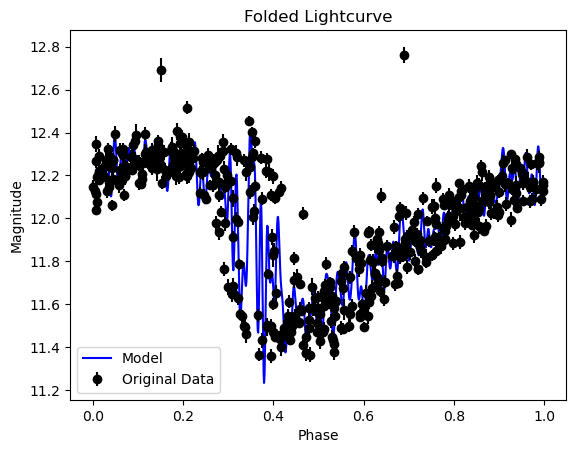

In [41]:
mcmc_res = np.percentile(chains2[::], 50, axis=0) #median of chain values
bestper = np.exp(mcmc_res[3])
print(bestper)

#folded lightcurve is plot of magnitude vs phase over one phase period
def phase(t):
    return ((t-t[0]))%bestper/bestper

ts = np.linspace(t[0], t[0]+bestper, 1000)
logA, gamma, logP = mcmc_res[1],mcmc_res[2],mcmc_res[3]
gp = george.GP(kernel = kernel(logA,gamma,logP))
gp.compute(t, m_err)
mu = gp.sample_conditional(mag, ts)
print(mu)
plt.figure()
phase1 = phase(t)
plt.errorbar(phase1, mag, yerr=m_err, c='k', zorder=3, label='Original Data',ls='',fmt='o')
plt.plot(phase(ts[:-1]), mu[:-1], color='b', zorder=2, label='Model')
"""
for draws in samples[np.random.choice(len(samples), size=10)]:
    logA, gamma, logP = draws[1],draws[2],draws[3]
    gp = george.GP(kernel = kernel(logA,gamma,logP))
    gp.compute(t, m_err)
    mu = gp.sample_conditional(mag, ts)
    plt.plot(phase(ts[:-1]), mu[:-1],color="g", alpha=0.5, zorder=1)
"""
plt.ylabel('Magnitude')
plt.xlabel('Phase')
plt.title('Folded Lightcurve')
plt.legend()

In [ ]:
#plot the model with 10 draws
ts = np.linspace(t[0], t[-1], 1000)
logA, gamma, logP = mcmc_res[1],mcmc_res[2],mcmc_res[3]
gp = george.GP(kernel = kernel(logA,gamma,logP))
gp.compute(t, m_err)
mu = gp.sample_conditional(mag, ts)
p_mu, p_var = gp.predict(mag, ts, return_var=True)

plt.figure()
plt.plot(ts, mu, color='b', zorder=2, label='Model')
plt.errorbar(t, mag, yerr=m_err, c='k', zorder=3, label='Data')
for draws in samples[np.random.choice(len(samples), size=10)]:#take 10 random draws from our samples
    logA, gamma, logP = draws[1],draws[2],draws[3]
    gp = george.GP(kernel = kernel(logA,gamma,logP))
    gp.compute(t, m_err)
    mu = gp.sample_conditional(mag, ts)
    plt.plot(ts, mu[:-1],color="g", alpha=0.5, zorder=1)
plt.title('GP Fitted Data with Random Draws')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

In [ ]:
#plot the uncertainty of the model
plt.figure()
plt.plot(ts, mu, color='b', zorder=2, label='Model')
plt.errorbar(t, mag, yerr=m_err,fmt='o', c='k', zorder=3, label='Data')
plt.fill_between(ts, p_mu - np.sqrt(p_var), p_mu + np.sqrt(p_var),c="g", \
                 alpha=0.5, label='Uncertainty', zorder=1)
plt.title('Model Uncertainty')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

N.B. you should be a bit worried about "burn in" and how the walkers were initialized throughout. If you plan to use GPs to search for periods in your own work, I highly recommend you read Angus et al. 2018 on the GP periodogram. Angus et al. provide far more intelligent methods for initializing the MCMC than what is presented here. 

### Q3: PyMC (yes, that thing), hierarchical mixture models, and the mass-radius relation for small exoplanets

The mass-radius relation is a relationship between the radius $R$ of an exoplanet and its mass $M$. We usually call planets smaller than the Neptune size $(R < 4 R_{\oplus})$ small planets. In the Solar System, we don't have any planets between the Earth and Neptune sizes ($ 1-4 R_{\oplus}$), whereas in extrasolar systems, plenty of planets with radii in the range are observed. Thus, it's extremely intriguing to study the compositions of these planets and understand why we don't have one in the Solar System.

In this problem, you will work on one of the papers that one of our colloquium speakers brought up (this is why you should go to colloquium btw, because it'd have totally helped with this final exam to know the answer) - the mass-radius relation for small exoplanets around M-dwarfs. 

The paper is by [Luque et al., Science 377, 1211 (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220903871L/abstract). We will reproduce some of their results using the PyMC.

In [2]:
## Download the dataset from Luque et al. 2022
data = pd.read_csv("https://carmenes.caha.es/ext/tmp/TMP.csv")
data.columns.values

array(['ID', 'ID_Star', 'Star', 'AltName', 'Karmn', 'RA_J2000',
       'DE_J2000', 'SpT', 'SpTnum', 'd_pc', 'ed_pc', 'Lbol_Lsol',
       'eLbol_Lsol', 'Teff_K', 'eTeff_K', 'R_Rsol', 'eR_Rsol', 'M_Msol',
       'eM_Msol', 'J_mag', 'eJ_mag', 'Ks_mag', 'eKs_mag', 'Planet', 'TOI',
       'Porb_d', 'a_au', 'R_Rterra', 'euR_Rterra', 'edR_Rterra',
       'M_Mterra', 'euM_Mterra', 'edM_Mterra', 'rho_gcm-3', 'eurho_gcm-3',
       'edrho_gcm-3', 'Teq_K', 'euTeq_K', 'edTeq_K', 'TSM', 'ESM',
       'Method', 'DiscoveryRef', 'ParameterRef'], dtype=object)

In [3]:
## Lets extract mass and radius and their uncertainties from the data; both M and R are in Earth units 
M = data.M_Mterra
R = data.R_Rterra

err_M = (data.edM_Mterra+data.euM_Mterra)/2  # Assume the + and - errors on M and R are symmetric because lazy
err_R = (data.edR_Rterra+data.euR_Rterra)/2

ind = err_R < 1.
M = M[ind]
R = R[ind]
err_M = err_M[ind]
err_R = err_R[ind]

c=data['rho_gcm-3'][ind]

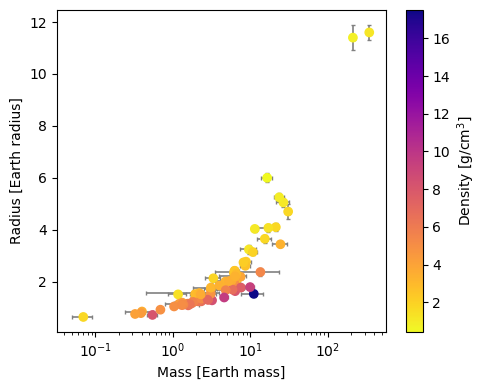

In [13]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(5,4))
plt.errorbar(M, R, xerr=err_M, yerr=err_R,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M, R, c=c, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Exoplaneteers made up cute names to describe planets in different compositions.
- "Rocky world" if a planet has a bulk density similar to the Earth.
- "Water world" if a planet has a bulk density consistent with 50% rocky and 50% water ice.
- "Puffy world" if a planet has a bulk density smaller than the "Water World" density.

Now, while it's possible that this final is making you wish you were on a "puff" of something or the other, we'll restrict our analysis to the rocky and water worlds. It's where the grant dollars are. 


### 3a - modeling the mass radius relation for rocky worlds (11 pts) 

First, select the rocky worlds. 

Let's write down the mass-radius relation for rocky worlds as a power law.

$R = aM^b$, where $a$ is proportional to $1/\rho_{\oplus}$, and $b$ is unitless. If the relation follows $M = \frac{4}{3}\pi R^3 \rho$, we have $a = 1$ and $b = 1/3$. However, in reality, the interior density of planets is not uniform and depends on the equation of state.

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

Hints:
- As a, b have to be positive, I'd suggest Uniform priors on log a, log b, and then using pm.Deterministic to exponentiate them 
- For the masses, since you've selected the rocky worlds, I'd suggest a normal distribution with the sample mean and sample standard deviation of the rocky worlds. 
- Given M, a, b you can use pm.Deterministic to get R_model
- Assume our favorite normal likelihood for R_model. You have the observed radius and their uncertainties from the file.

In [4]:
import pymc as pm
import numpy as np

def model(a,b,m):
    return a*m**b

#select rocky planets (earth-like density rho~5.51 g/cm^3)
maskR = (c.values>=5.51*2/3) #assume all planets with rho>5.51 are rocky, but use 2/3 as minimum cutoff 
Mr = M.values[maskR]
Rr = R.values[maskR]
err_Mr = err_M.values[maskR]
err_Rr = err_R.values[maskR]
cr = c.values[maskR]
print(Mr)

[ 6.38   1.76   3.21   6.36   2.33   2.87   1.54   7.57   1.58   1.58
  2.14   3.09   1.86   2.22   5.77   7.49   1.84   0.546  5.9    1.66
  2.34  11.1    2.82  13.5    1.21   4.82   1.32   9.95   1.374  1.308
  0.388  0.692  1.039  1.321  0.326  4.6  ]


In [5]:
with pm.Model() as hierarchical_model: 

    # Hyperpriors for group nodes
    #Ms = pm.Normal('mass', mu = np.mean(M), sigma = np.std(M), shape = len(M))
    loga = pm.Uniform('loga', lower = -2, upper=5)
    logb = pm.Uniform('logb', lower= -2, upper = 2)
    
    a = pm.Deterministic('a', np.exp(loga))
    b = pm.Deterministic('b', np.exp(logb))
    
    mu = pm.Deterministic('R_model',a*Mr**b)#pm.Deterministic('R_model',a*Ms**b)
    like = pm.Normal('likelihood', mu=mu, sigma=err_Rr, observed=Rr)
    
    hm = pm.sample(2000, tune=500, chains = 4, cores = 4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [loga, logb]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 4 seconds.


In [6]:
res_hm = pm.summary(hm)
res_hm

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
loga         0.025  0.004   0.017    0.033        0.0      0.0    5557.0   
logb        -1.266  0.018  -1.300   -1.230        0.0      0.0    5113.0   
a            1.025  0.004   1.017    1.033        0.0      0.0    5557.0   
b            0.282  0.005   0.273    0.292        0.0      0.0    5113.0   
R_model[0]   1.729  0.016   1.699    1.759        0.0      0.0    6754.0   
R_model[1]   1.202  0.005   1.192    1.212        0.0      0.0    8254.0   
R_model[2]   1.424  0.009   1.408    1.442        0.0      0.0    7857.0   
R_model[3]   1.727  0.016   1.698    1.758        0.0      0.0    6758.0   
R_model[4]   1.301  0.007   1.289    1.314        0.0      0.0    8426.0   
R_model[5]   1.380  0.008   1.366    1.396        0.0      0.0    8103.0   
R_model[6]   1.158  0.005   1.149    1.167        0.0      0.0    7749.0   
R_model[7]   1.814  0.018   1.780    1.849        0.0      0.0    6584.0   
R_model[8]   1.166  0.005   1.157    1.176        0.0      0.0    7864.0   
R_model[9]   1.166  0.005   1.157    1.176        0.0      0.0    7864.0   
R_model[10]  1.271  0.006   1.258    1.282        0.0      0.0    8481.0   
R_model[11]  1.409  0.009   1.394    1.426        0.0      0.0    7939.0   
R_model[12]  1.221  0.005   1.211    1.232        0.0      0.0    8375.0   
R_model[13]  1.284  0.006   1.272    1.296        0.0      0.0    8471.0   
R_model[14]  1.681  0.015   1.653    1.709        0.0      0.0    6870.0   
R_model[15]  1.809  0.018   1.775    1.843        0.0      0.0    6594.0   
R_model[16]  1.218  0.005   1.207    1.228        0.0      0.0    8352.0   
R_model[17]  0.864  0.005   0.855    0.874        0.0      0.0    4517.0   
R_model[18]  1.691  0.015   1.663    1.720        0.0      0.0    6844.0   
R_model[19]  1.183  0.005   1.173    1.192        0.0      0.0    8068.0   
R_model[20]  1.303  0.007   1.290    1.316        0.0      0.0    8423.0   
R_model[21]  2.021  0.024   1.975    2.067        0.0      0.0    6293.0   
R_model[22]  1.373  0.008   1.359    1.389        0.0      0.0    8139.0   
R_model[23]  2.136  0.028   2.083    2.188        0.0      0.0    6185.0   
R_model[24]  1.082  0.004   1.073    1.090        0.0      0.0    6447.0   
R_model[25]  1.598  0.013   1.574    1.622        0.0      0.0    7117.0   
R_model[26]  1.109  0.005   1.100    1.117        0.0      0.0    6931.0   
R_model[27]  1.960  0.022   1.917    2.002        0.0      0.0    6366.0   
R_model[28]  1.121  0.005   1.112    1.130        0.0      0.0    7162.0   
R_model[29]  1.106  0.005   1.097    1.114        0.0      0.0    6880.0   
R_model[30]  0.785  0.006   0.774    0.796        0.0      0.0    4443.0   
R_model[31]  0.924  0.005   0.915    0.933        0.0      0.0    4698.0   
R_model[32]  1.036  0.004   1.028    1.044        0.0      0.0    5707.0   
R_model[33]  1.109  0.005   1.100    1.117        0.0      0.0    6935.0   
R_model[34]  0.747  0.006   0.736    0.759        0.0      0.0    4443.0   
R_model[35]  1.577  0.012   1.554    1.600        0.0      0.0    7189.0   

             ess_tail  r_hat  
loga           5420.0    1.0  
logb           4781.0    1.0  
a              5420.0    1.0  
b              4781.0    1.0  
R_model[0]     5255.0    1.0  
R_model[1]     5742.0    1.0  
R_model[2]     5547.0    1.0  
R_model[3]     5255.0    1.0  
R_model[4]     5603.0    1.0  
R_model[5]     5447.0    1.0  
R_model[6]     5432.0    1.0  
R_model[7]     5255.0    1.0  
R_model[8]     5612.0    1.0  
R_model[9]     5612.0    1.0  
R_model[10]    5535.0    1.0  
R_model[11]    5649.0    1.0  
R_model[12]    5679.0    1.0  
R_model[13]    5622.0    1.0  
R_model[14]    5329.0    1.0  
R_model[15]    5255.0    1.0  
R_model[16]    5702.0    1.0  
R_model[17]    4751.0    1.0  
R_model[18]    5329.0    1.0  
R_model[19]    5843.0    1.0  
R_model[20]    5603.0    1.0  
R_model[21]    5165.0    1.0  
R_model[22]    5497.0    1.0  
R_model[23]    5254.0    1.0 

<Figure size 640x480 with 0 Axes>

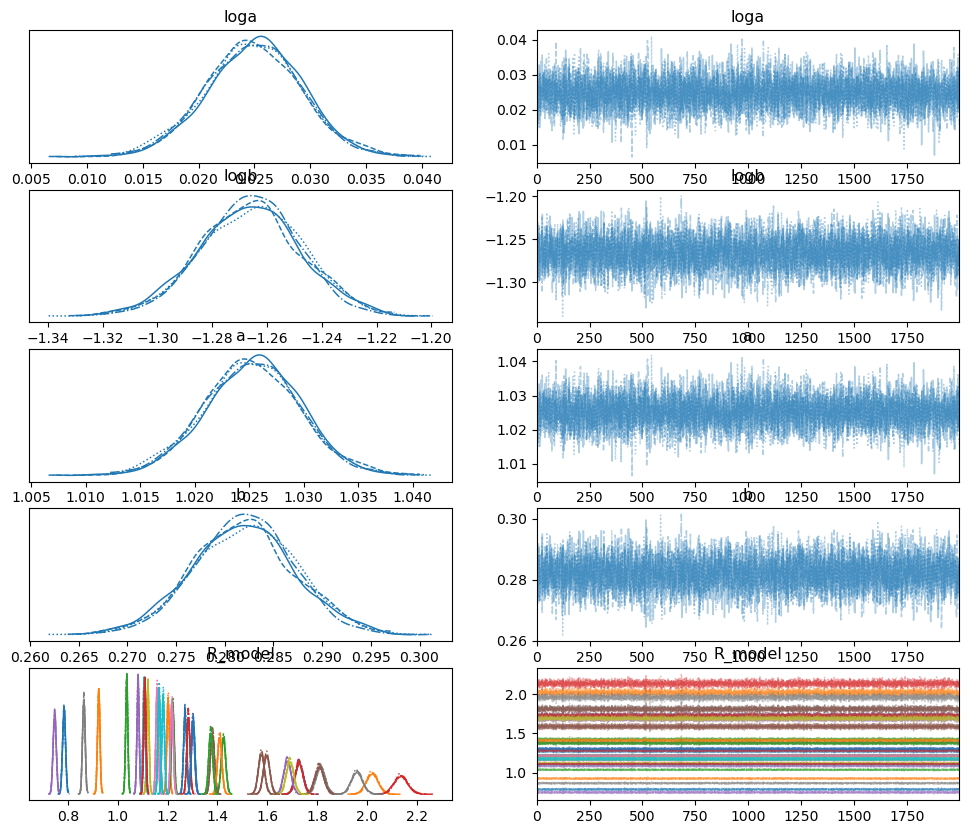

In [7]:
plt.figure(layout='tight')
pm.plot_trace(hm);

In [8]:
post_a = np.asarray(hm.posterior['a'])
post_b = np.asarray(hm.posterior['b'])
a_fit = np.mean(post_a)
b_fit = np.mean(post_b)
print(a_fit,b_fit)

percentile_rang = (5,95)

arang = np.percentile(post_a,percentile_rang)
brang = np.percentile(post_b,percentile_rang)
print(arang,brang)

1.0252563265324024 0.2819794583072242
[1.0179297  1.03242832] [0.27342362 0.29062344]


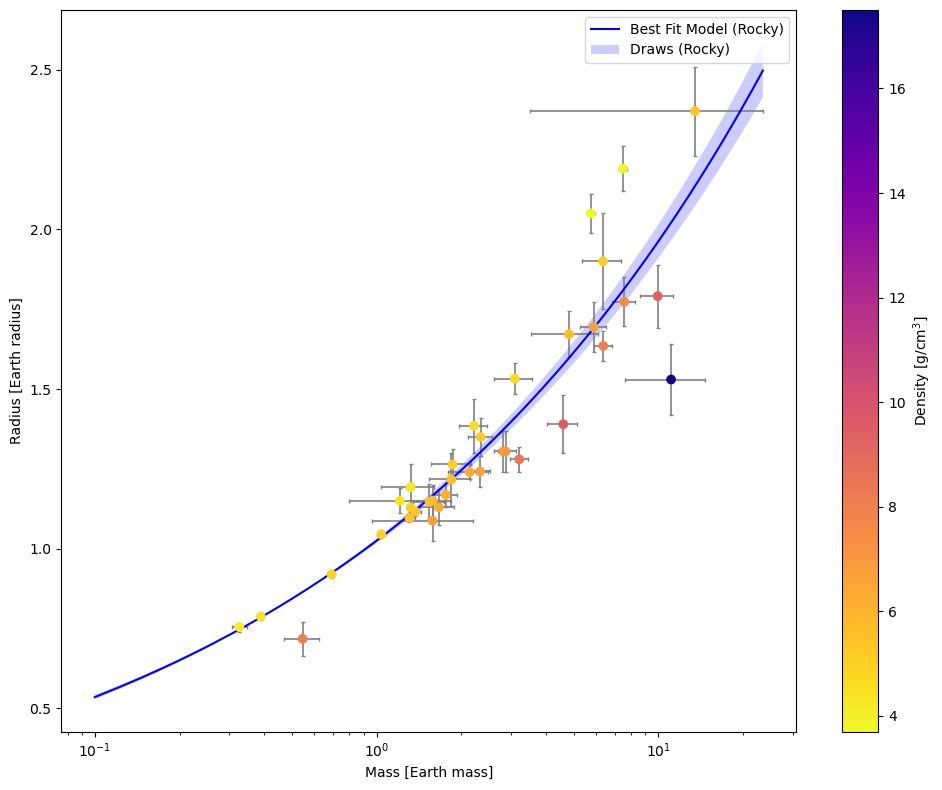

In [9]:
x = np.linspace(0.1,np.max(Mr)+10,1000)
rt = model(a_fit,b_fit,x)
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(10,8))
plt.errorbar(Mr, Rr, xerr=err_Mr, yerr=err_Rr,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(Mr, Rr, c=cr, zorder=100, cmap='plasma_r')
plt.plot(x,rt,c='b',label= 'Best Fit Model (Rocky)')
plt.fill_between(x,model(arang[0],brang[0],x),model(arang[1],brang[1],x), fc = 'b', alpha=0.2,\
                label = 'Draws (Rocky)')


plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.legend()
plt.tight_layout()
plt.show()

### 3b - The Mass-Radius Relation for Rocky+Water Worlds (23 pts) 

Let's now add water worlds and model the mass-radius relation for both rocky and water worlds. Physically, it will require two models to describe the mass-radius relations for rocky and water worlds. The tricky part is we don't know exactly which kind of worlds a planet is belong to. In this situation, it is helpful to introduce a categorical variable `z` that is either 0 or 1, with the relative posterior probabilities telling us how Rocky/Watery a planet is.

Select the Rocky Water worlds - see the categories above 3a again. 

To make this work like magic with PyMC and it's Monte-Carlo sampler, we can choose a special prior for our categorial variable: the Drichlet Prior - https://en.wikipedia.org/wiki/Dirichlet_distribution

    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(RockyWaterWorlds))
    

The rest of the PyMC model should be the same as 3a except you are fitting two relations - one for rocky worlds and one for water worlds, so you need two different `a` and `b` parameters - `shape=2` as above should take it. You might want to sort the `a` parameter with `transform=pm.distributions.transforms.ordered` when you define the prior to sort things. 

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

In [10]:
#select rocky planets (earth-like density rho~5.51 g/cm^3)
#just selecting planets based on density wasn't giving good fits so here's a more 
# specified approach:
#from googling, the estimated maximum mass for rocky planets is ~10 earth masses
# and around 2-3 earth radii. this coupled with the density of water being 1 g/cm^3
# gives the constraints below.
maskW = (M.values<=10) &(R.values<3.5)&(c.values>1)
Mw = M.values[maskW]
Rw = R.values[maskW]
err_Mw = err_M.values[maskW]
err_Rw = err_R.values[maskW]
cw = c.values[maskW]

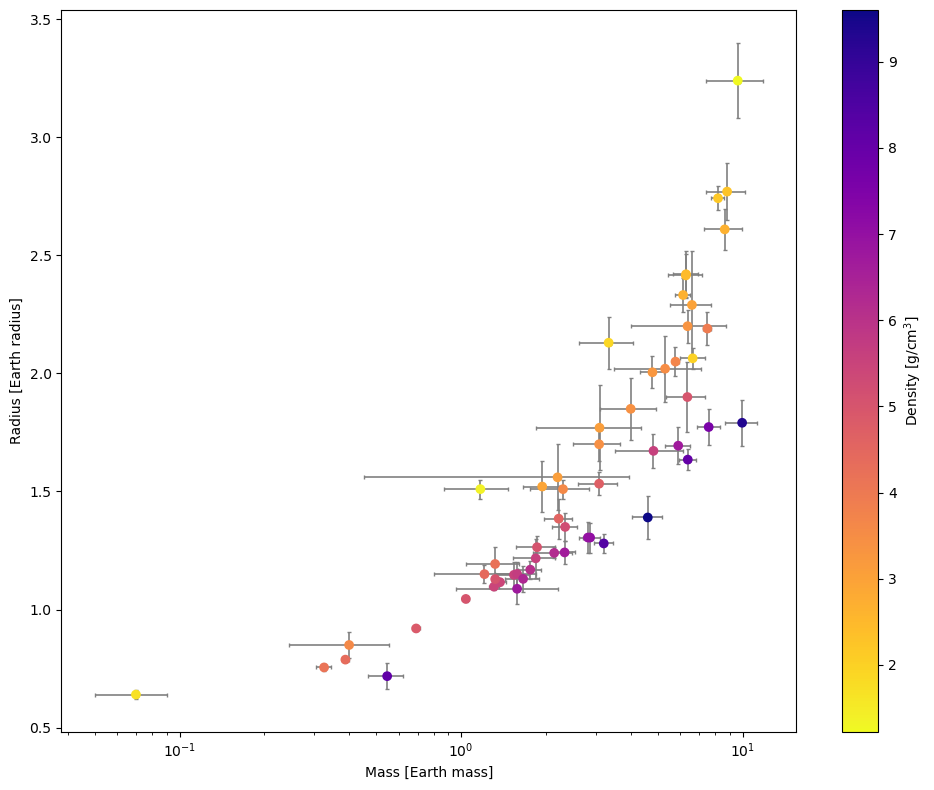

In [16]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(10,8))
plt.errorbar(Mw, Rw, xerr=err_Mw, yerr=err_Rw,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(Mw, Rw, c=cw, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

In [12]:
with pm.Model() as hierarchical_model: 

    # Hyperpriors for group nodes
    #Ms = pm.Normal('mass', mu = np.mean(M), sigma = np.std(M), shape = len(M))
    loga = pm.Uniform('loga', lower = -2, upper=5, shape=2)
    logb = pm.Uniform('logb', lower= -2, upper = 2, shape = 2)
    
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(Rw))
    
    #a = pm.Uniform('a', lower=0,upper=10,shape = 2)
    #b = pm.Uniform('b', lower=0,upper=10,shape = 2)
    a = pm.Deterministic('a', np.exp(loga))
    b = pm.Deterministic('b', np.exp(logb))
    transform= pm.distributions.transforms.Ordered

    
    mu = pm.Deterministic('R_model',(1-z)*a[0]*Mw**b[0]+z*(a[1]*Mw**b[1]))
    like = pm.Normal('likelihood', mu=mu, sigma=err_Rw, observed=Rw)
    hm2 = pm.sample(2000, tune=500, target_accept=0.9)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [logslope, logpow, p]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 52 seconds.


<Figure size 640x480 with 0 Axes>

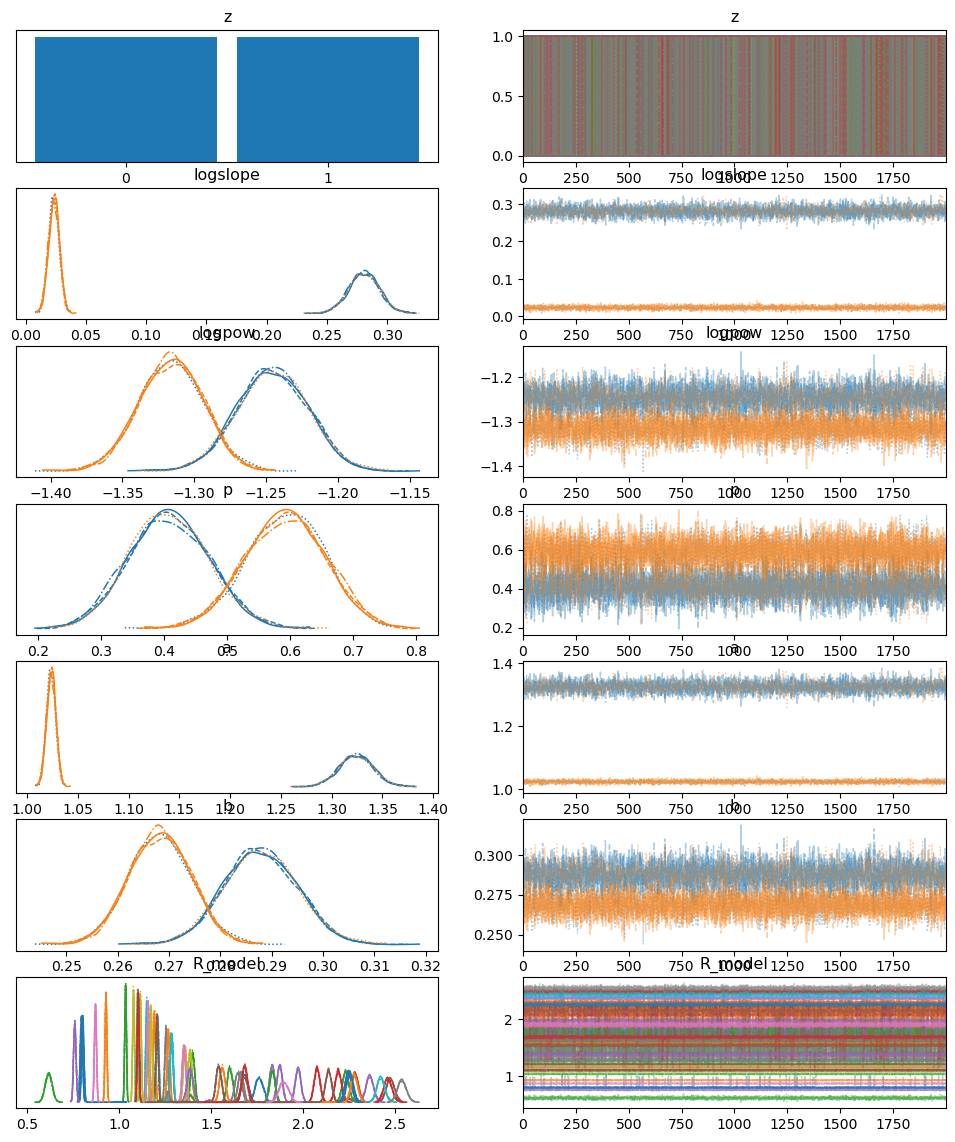

In [13]:
plt.figure(layout='tight')
pm.plot_trace(hm2);

In [14]:
res_hm = pm.summary(hm2)
res_hm

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z[0]         0.750  0.433   0.000    1.000      0.216    0.166       4.0   
z[1]         0.750  0.433   0.000    1.000      0.216    0.166       4.0   
z[2]         0.750  0.433   0.000    1.000      0.216    0.166       4.0   
z[3]         0.250  0.433   0.000    1.000      0.216    0.166       4.0   
z[4]         0.250  0.433   0.000    1.000      0.216    0.166       4.0   
...            ...    ...     ...      ...        ...      ...       ...   
R_model[51]  0.928  0.005   0.919    0.937      0.000    0.000    5695.0   
R_model[52]  1.034  0.005   1.026    1.043      0.000    0.000    6302.0   
R_model[53]  1.103  0.005   1.094    1.112      0.000    0.000    6888.0   
R_model[54]  0.758  0.007   0.746    0.771      0.000    0.000    5616.0   
R_model[55]  1.542  0.014   1.517    1.570      0.000    0.000    6755.0   

             ess_tail         r_hat  
z[0]              4.0  5.617601e+15  
z[1]              4.0  5.617601e+15  
z[2]              4.0  5.617601e+15  
z[3]              4.0  4.627524e+15  
z[4]              4.0  4.627524e+15  
...               ...           ...  
R_model[51]    4985.0  1.000000e+00  
R_model[52]    5216.0  1.000000e+00  
R_model[53]    5093.0  1.000000e+00  
R_model[54]    4724.0  1.000000e+00  
R_model[55]    5249.0  1.000000e+00  

[122 rows x 9 columns]

In [15]:
posteriors = hm2.posterior
post_a = np.asarray(posteriors['a']).flatten()
post_b = np.asarray(posteriors['b']).flatten()
print(post_a)
a0s = []
a1s = []
#for i in range(len(post_a)):
for a in post_a:#[i]:
    if a>1.10:
        a1s.append(a)
    else:
        a0s.append(a)

b0s = []
b1s = []
#for i in range(len(post_b)):
for b in post_b:
    #around the point of intersection on the traceplot above
    if b>.277:
        b1s.append(b)
    else:
        b0s.append(b)

[1.34040394 1.02480119 1.34054757 ... 1.03314937 1.30359224 1.0318526 ]


In [ ]:
'a_dim_0','chain','draw'

In [16]:
x = np.linspace(np.min(Mw)-1,np.max(Mw)+10,1000)
a0_fit = np.mean(a0s)
b0_fit = np.mean(b0s)
a1_fit = np.mean(a1s)
b1_fit = np.mean(b1s)

percentile_rang = (5,95)

a0srang = np.percentile(a0s,percentile_rang)
a1srang = np.percentile(a1s,percentile_rang)
b0srang = np.percentile(b0s,percentile_rang)
b1srang = np.percentile(b1s,percentile_rang)
print(a0_fit,a1_fit,b0_fit,b1_fit)
print(a0srang,b0srang,a1srang,b1srang)

1.023838571789583 1.3241092946809607 0.26776821426454284 0.28810302633573015
[1.01625134 1.03134419] [0.25833437 0.2758138 ] [1.29680094 1.35132229] [0.27818972 0.2993466 ]


/tmp/ipykernel_381/2811363205.py:5: RuntimeWarning: invalid value encountered in power
  return a*m**b


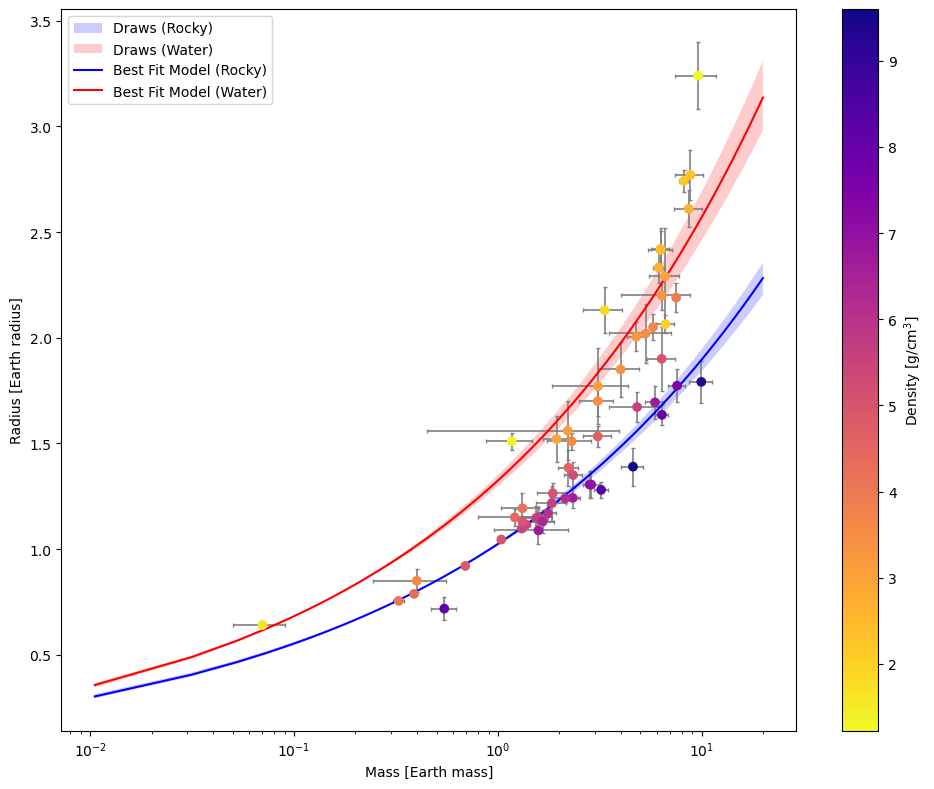

In [17]:
rt0= model(a0_fit,b0_fit,x)
rt1 = model(a1_fit,b1_fit,x)
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(10,8))
plt.errorbar(Mw, Rw, xerr=err_Mw, yerr=err_Rw,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(Mw, Rw, c=cw, zorder=100, cmap='plasma_r')


plt.fill_between(x,model(a0srang[0],b0srang[0],x),model(a0srang[1],b0srang[1],x), fc= 'b', alpha=.2,\
                 label='Draws (Rocky)')
plt.fill_between(x,model(a1srang[0],b1srang[0],x),model(a1srang[1],b1srang[1],x), fc= 'r', alpha=.2,\
                label='Draws (Water)')

plt.plot(x,rt0,c='b', label = 'Best Fit Model (Rocky)')
plt.plot(x,rt1,c='r', label = 'Best Fit Model (Water)')
#plt.xlim(0.1,10*5)
#plt.ylim(0.2,6)
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.legend()
plt.tight_layout()
plt.show()

### Throughout, make sure your plots have things like appropriate axes scales, axes labels, errorsbars, legends, reasonable colors. Remember, these are how you tell the story of what you've done, and ultimately what we're looking at.  


### Get started. You know how to do all of this. If not, there's something in a class notebook that can help. I'm on Teams, so direct questions there. 

# Best of luck. You've got this. 